# Intensity variance issues across datasets: an exploration

Intensity may vary across different datasets, and it may vary differently on different tissues. In the simplest case scenario of intensity vairnace across daatasets some are simply lighter than others. What we could expect is more complicated. Some MRI machines may match each other in intensity on some materials i.e. air; but not others i.e. certain tissues. 
We can automatically set the "air" around a brain MRI to zero, however the question of matching intensities in the tissues remains,
This notebook represents initial approaches to the problem. An augemented pair of datasets of will be created, which do not match in intensity distribution, and then remapped.  

### Imports
The data will be processed using the libraries and modules below:

In [1]:
import os       # using operating system dependent functionality (folders)
import glob
import pandas as pd # data analysis and manipulation
import numpy as np    # numerical computing (manipulating and performing operations on arrays of data)
import copy     # Can Copy and Deepcopy files so original file is untouched.
from ipywidgets import IntSlider, Output
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage
#import hashlib
import sys
sys.path.insert(0, '../') # path to functions
from cvasl import file_handler as fh # 
from cvasl import mold #
from cvasl import carve
from cvasl.file_handler import Config

### Load image files
Use the config pathways for the different datasets, then view one image as an example.

In [2]:
config = Config()
root_mri_directory = config.get_directory('root_mri_directory')

In [3]:
mri_pattern = os.path.join(root_mri_directory, '**/*.gz')
gz_files = glob.glob(mri_pattern, recursive=True)

In [4]:
gz_files

['C:/Projects/brainspin/not_pushed/data_anonymized\\EPAD\\040EPAD00007_3\\ASL_1\\CBF.nii.gz',
 'C:/Projects/brainspin/not_pushed/data_anonymized\\EPAD\\040EPAD00007_3\\ASL_1\\M0.nii.gz',
 'C:/Projects/brainspin/not_pushed/data_anonymized\\EPAD\\040EPAD00007_3\\ASL_1\\PWI.nii.gz',
 'C:/Projects/brainspin/not_pushed/data_anonymized\\HCP\\HCA6061757\\T1.nii.gz',
 'C:/Projects/brainspin/not_pushed/data_anonymized\\HCP\\HCA6061757\\T2w.nii.gz',
 'C:/Projects/brainspin/not_pushed/data_anonymized\\Insight46\\sub-19996829_2\\FLAIR.nii.gz',
 'C:/Projects/brainspin/not_pushed/data_anonymized\\Insight46\\sub-19996829_2\\T1_ORI.nii.gz',
 'C:/Projects/brainspin/not_pushed/data_anonymized\\Insight46\\sub-19996829_2\\ASL_1\\ASL4D.nii.gz',
 'C:/Projects/brainspin/not_pushed/data_anonymized\\Insight46\\sub-19996829_2\\ASL_1\\CBF.nii.gz',
 'C:/Projects/brainspin/not_pushed/data_anonymized\\Insight46\\sub-19996829_2\\ASL_1\\M0.nii.gz',
 'C:/Projects/brainspin/not_pushed/data_anonymized\\Insight46\\sub-19

In [5]:
# an example path to an mrid brain .nii image:
t1_fn = gz_files[0]
# read the .nii image containing the volume with SimpleITK:
sitk_t1 = sitk.ReadImage(t1_fn)
# and access the numpy array:
t1 = sitk.GetArrayFromImage(sitk_t1)
# now display it
mold.SliceViewer(t1)

interactive(children=(Dropdown(description='View:', options=('axial', 'sag', 'cor'), value='axial'), Output())…

### Create augmented datasets
Here we will copy our base dataset to create two seperate datasets which we will change in terms of intensity values.

In [6]:
# just make two identical array sets
arrays_dataset_1 = []
arrays_dataset_2 = []
names = []
together = []
together_2 = []
for file in gz_files:
    read_file = sitk.ReadImage(file)
    arrayed_file = sitk.GetArrayFromImage(read_file)
    arrays_dataset_1.append(arrayed_file)
    arrays_dataset_2.append(arrayed_file)
    names.append(file)
    together.append((file, arrayed_file))
    together_2.append((file, arrayed_file))

In [7]:
#together[0]

In [8]:
#together[0][1].min(),together[0][1].max(), int(abs(together[0][1].min()- together[0][1].max()))

In [9]:
# and how many pixels?
together[0][1].shape[0]*together[0][1].shape[1]*together[0][1].shape[2]

147456

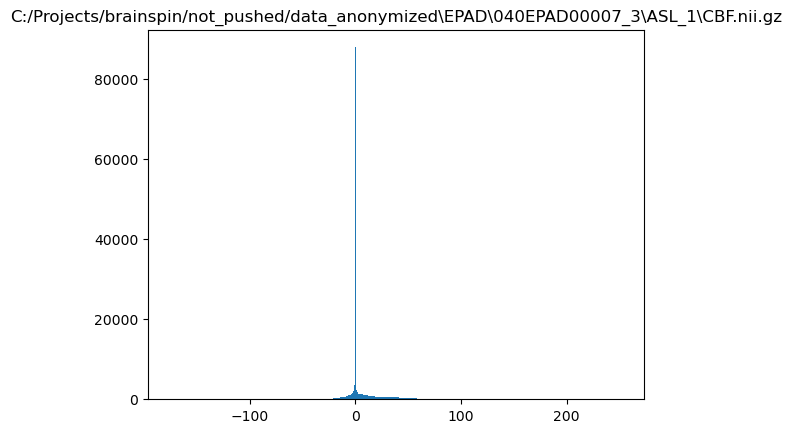

In [10]:
# show example of first in array_dataset
plt.hist(together[0][1].ravel(),425,[-175,252])
plt.title(together[0][0])
plt.show()


OK, but let's see what scale these were all on, before we go further

In [11]:
for image in arrays_dataset_1:
    print(image.min(), image.max(), image.shape[0]*image.shape[1]*image.shape[2])

-174.15114 251.11163 147456
0.0 2541.0916 147456
-101.39129 280.59042 147456
0.0 2931.5 19968000
0 1659 19968000
0.0 4095.875 11534336
0.0 4096.0 13631488
0 3855 80640
-397.21396 306.91333 516096
0 1295 8064
-177.23936 160.17757 516096
-84.125 4095.875 11796480
0.0 4096.0 11796480
0.0 2292.9343 112000
-269.84933 345.70538 128000
0.0 2361.1045 128000
-135.97383 151.12592 128000
0.0 4095.875 10354688
0.0 4096.0 12320768
-46.0 1075.0 13312
0.0 93.08526 851968
-46 1075 851968
0.0 481.0 851968
0.0 4095.875 11010048
0.0 4096.0 13107200
-96 1153 13824
0.0 119.90539 884736
-96 1153 884736
0.0 478.0 884736


So our pixel values were set in floating points ranging from -177 to over 4000, and some images are very large. This richness of information is something we probably want to keep. 

In [12]:
# # show example of first in array_dataset
# for name, image in together:
#     plt.hist(image.ravel(),bins=100,range=[image.min(),image.max()])
#     plt.title(name)
#     plt.show()


### Creating an artificially darker dataset, or dataset 'tanning' array_group_2,if you will

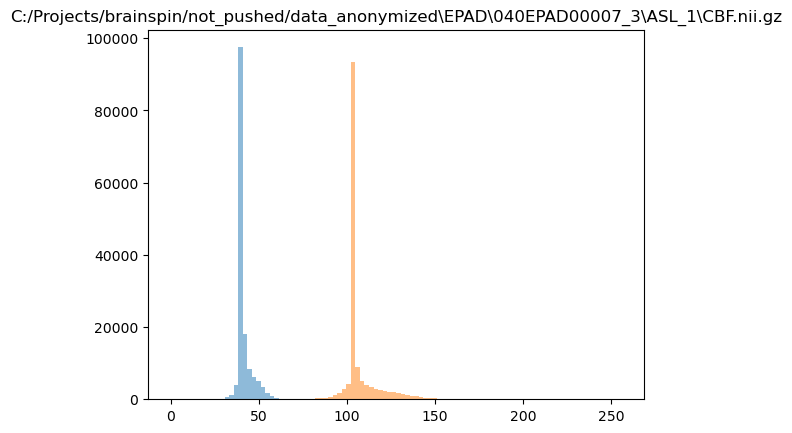

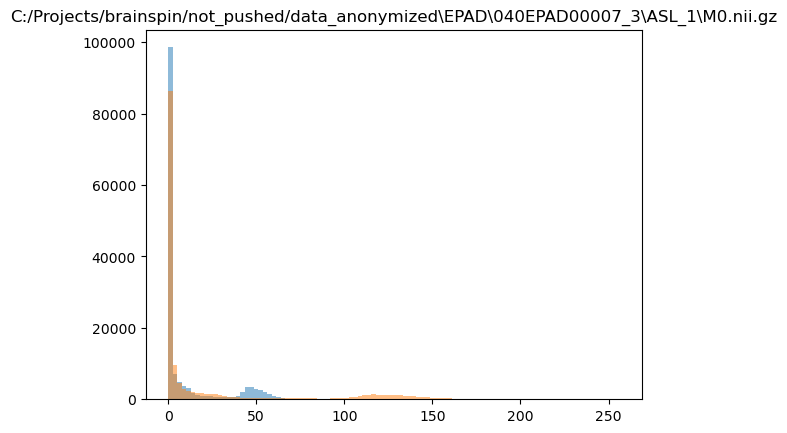

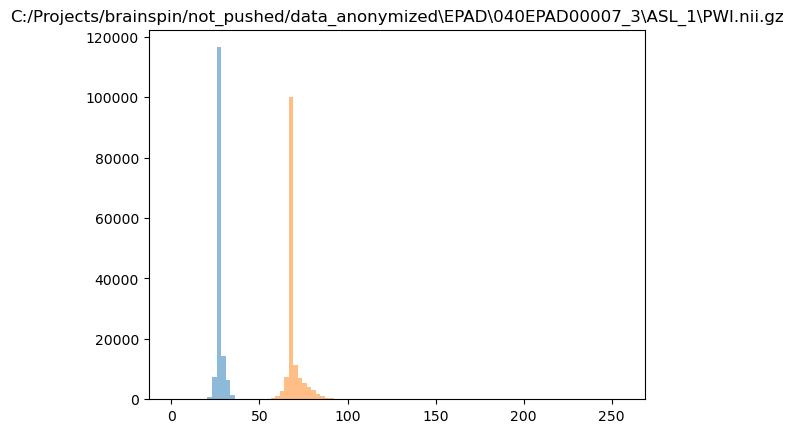

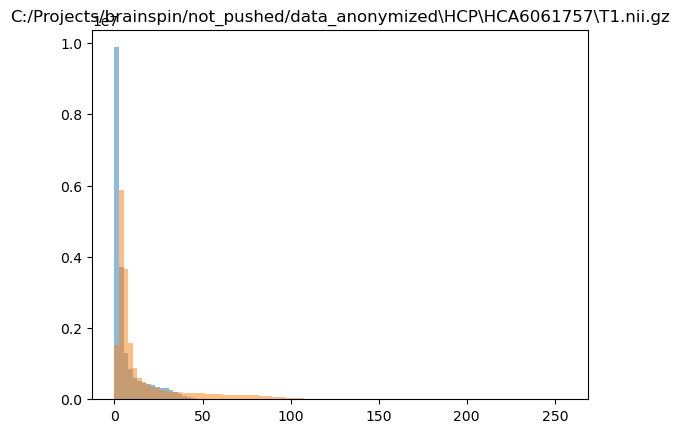

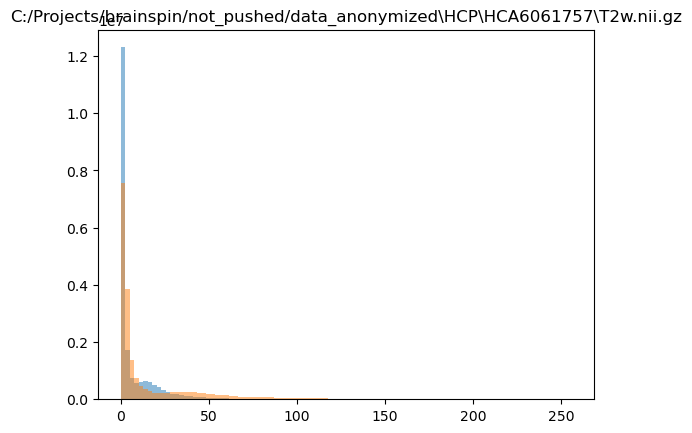

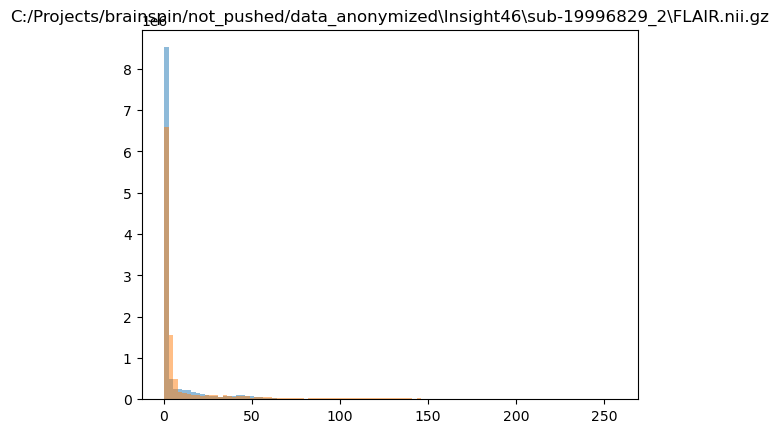

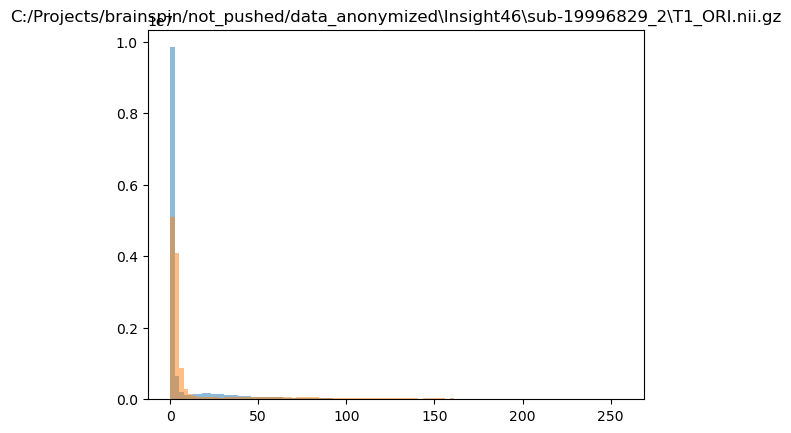

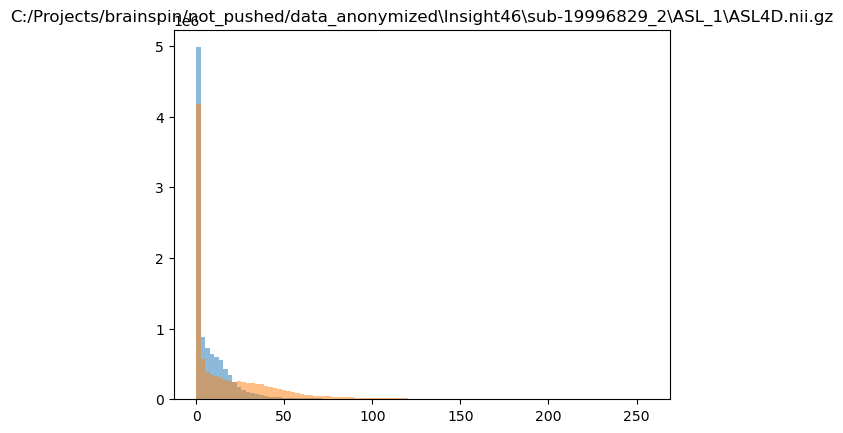

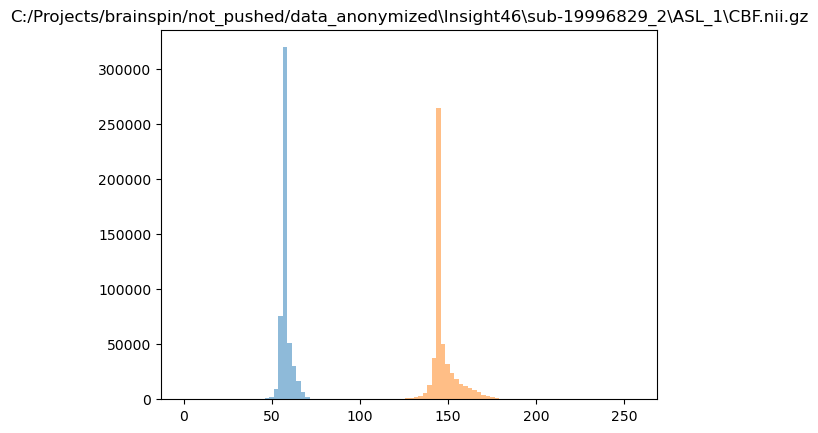

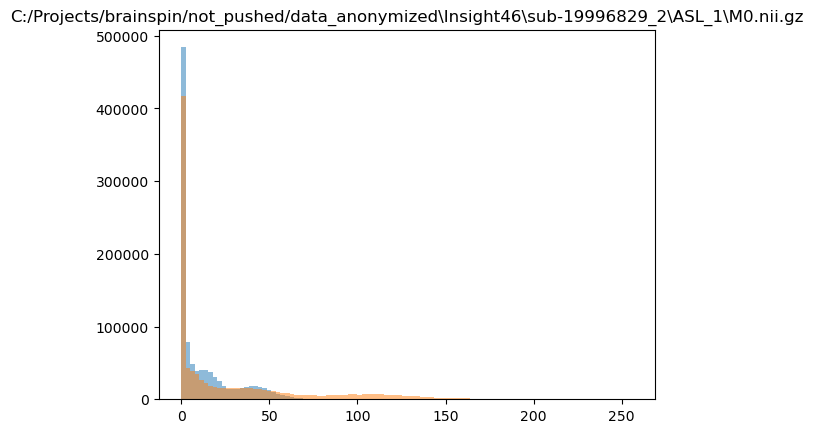

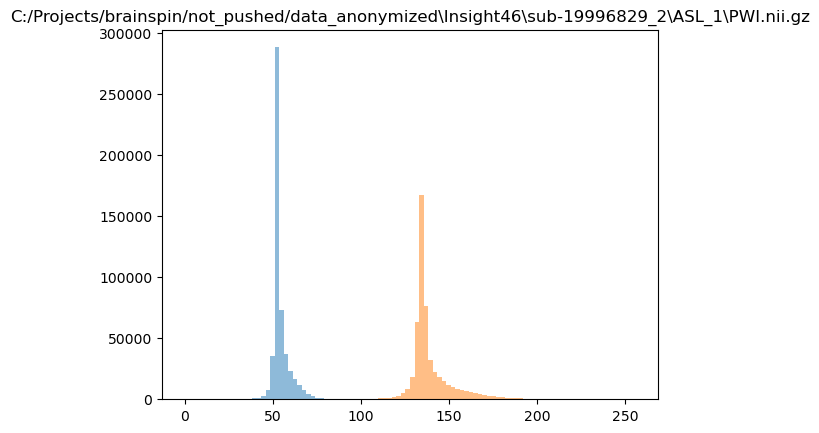

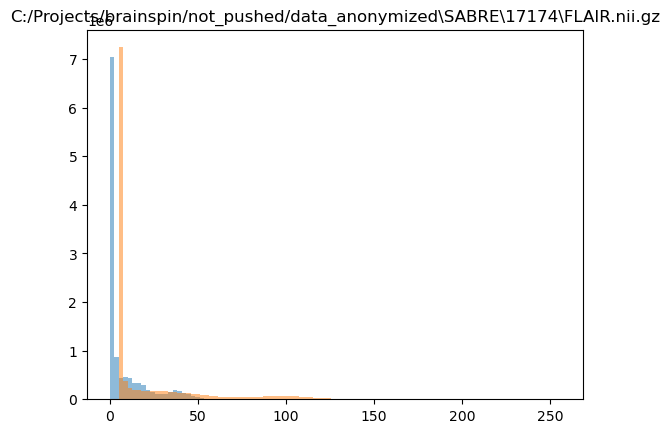

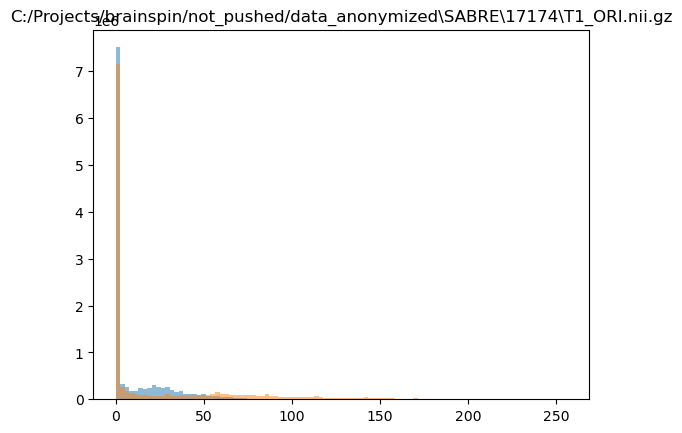

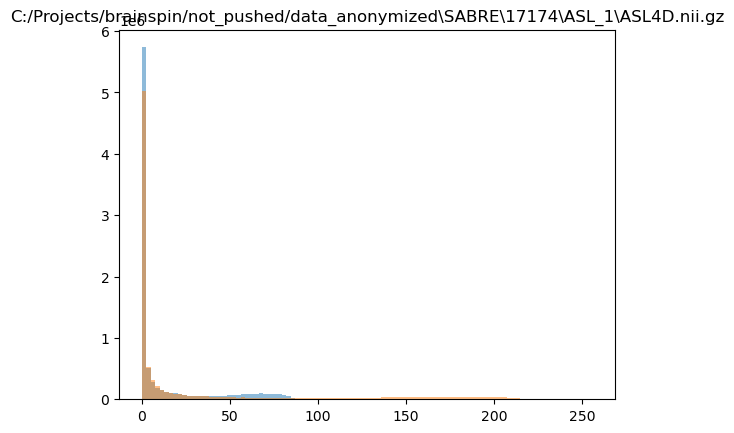

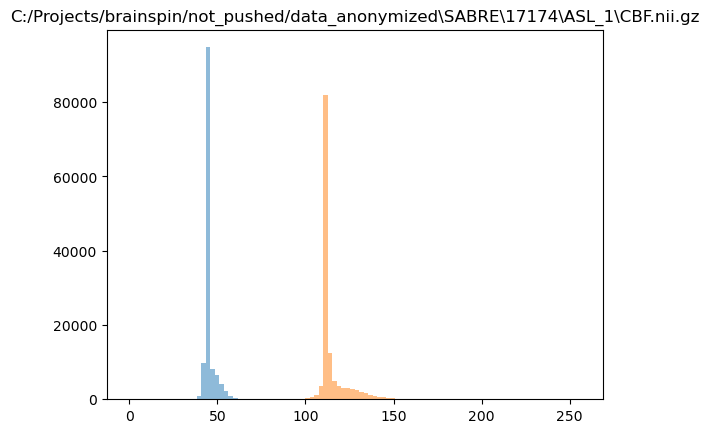

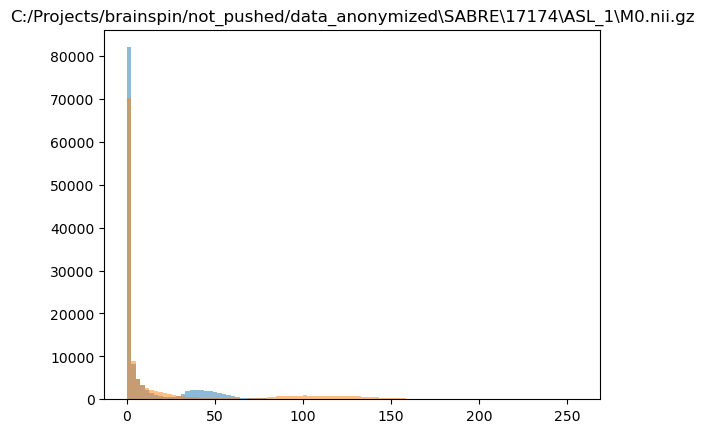

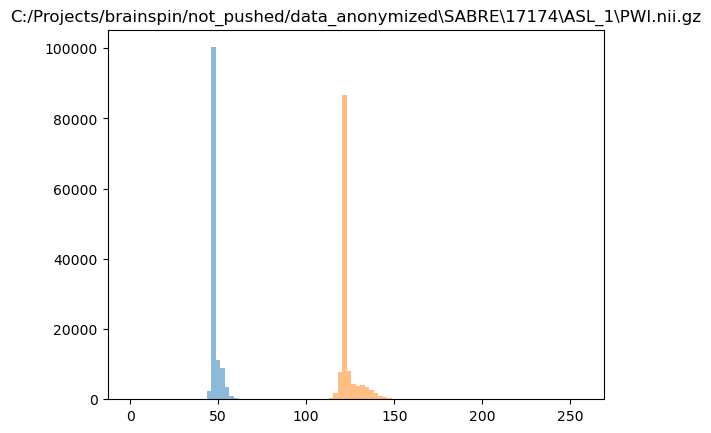

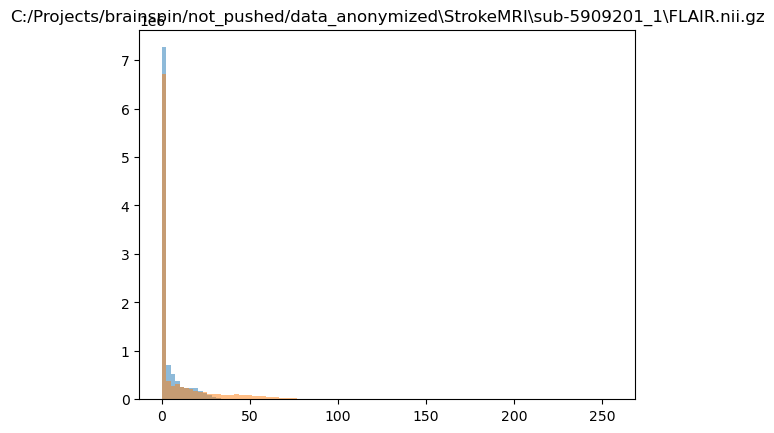

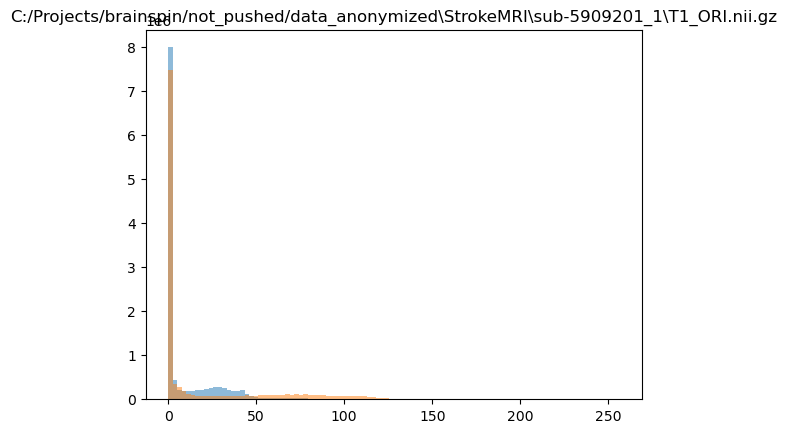

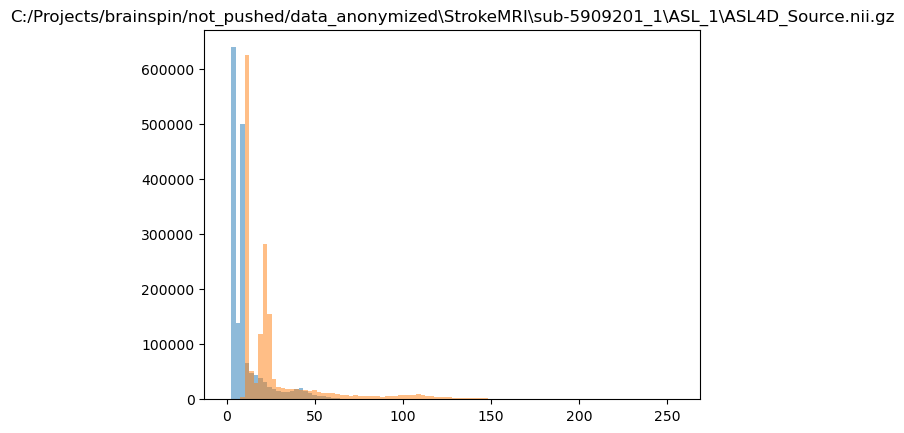

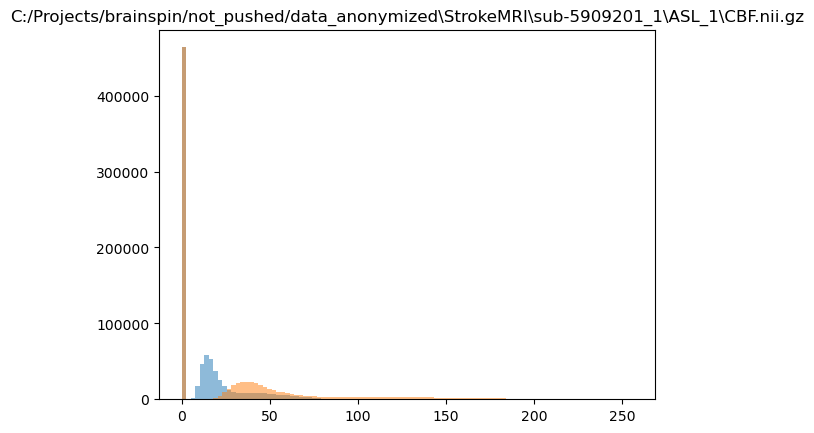

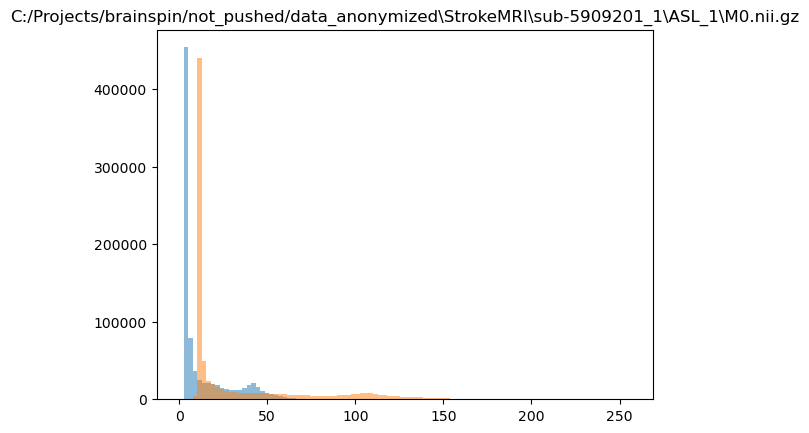

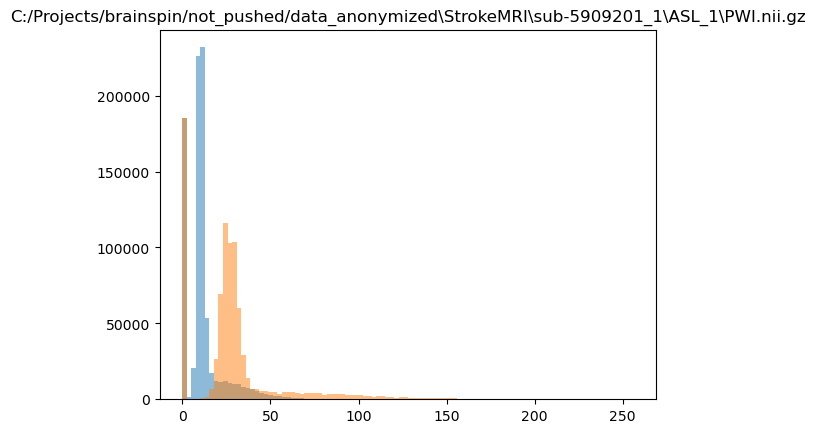

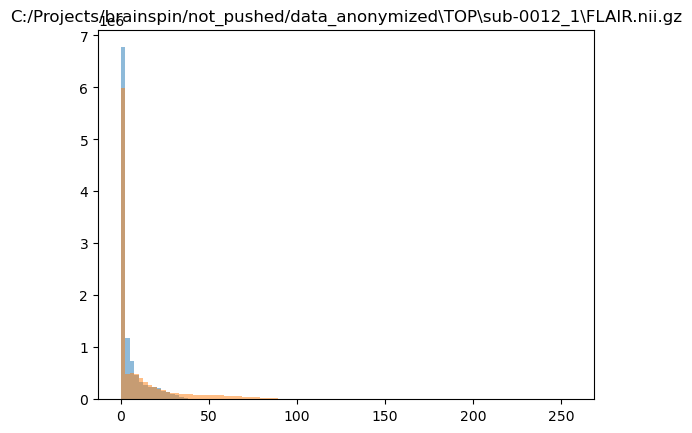

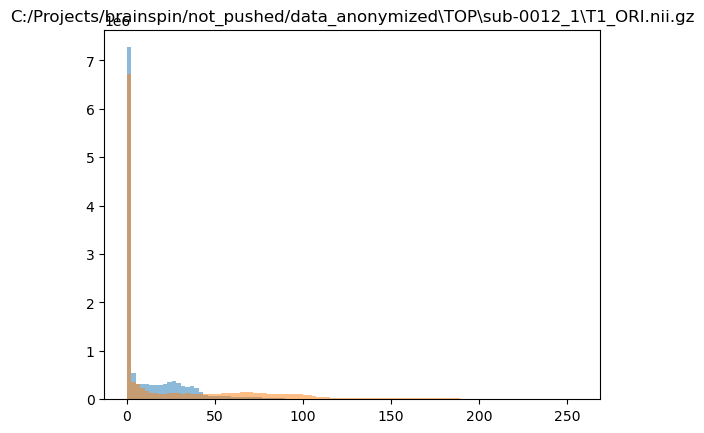

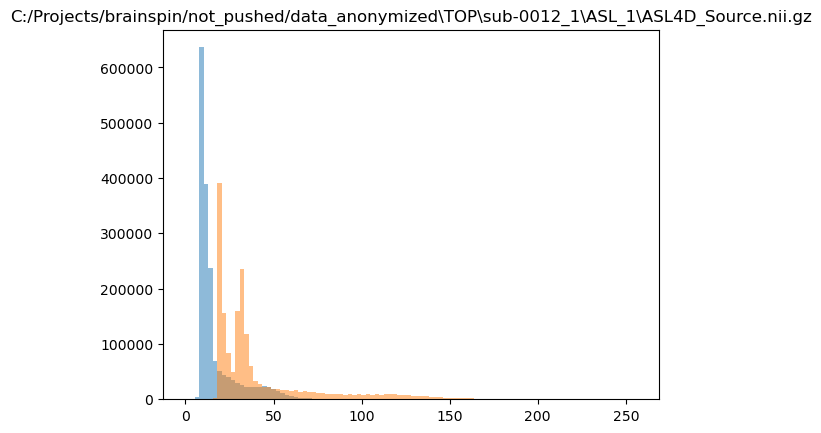

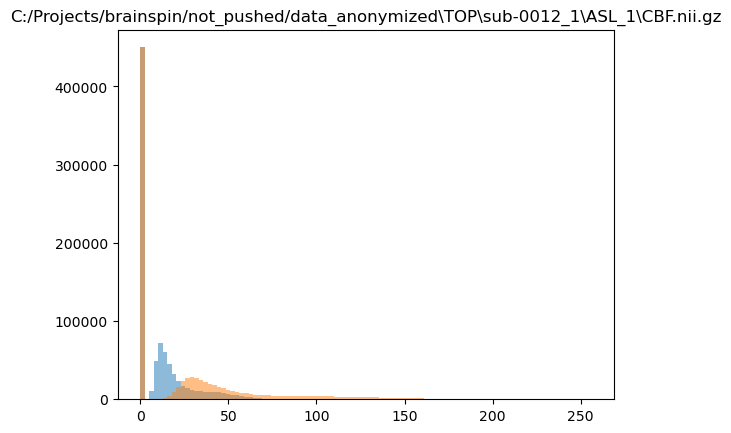

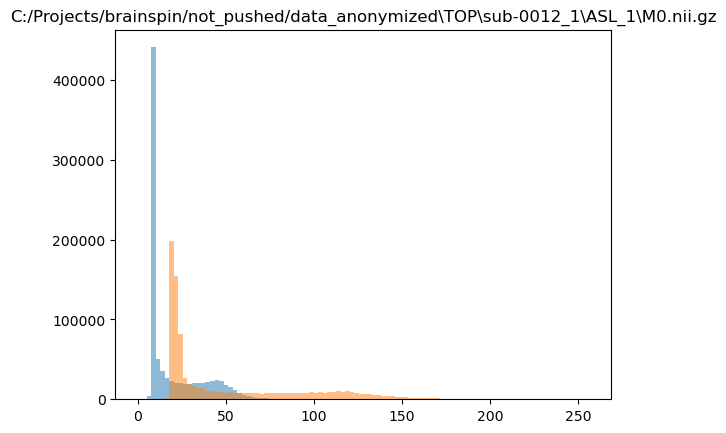

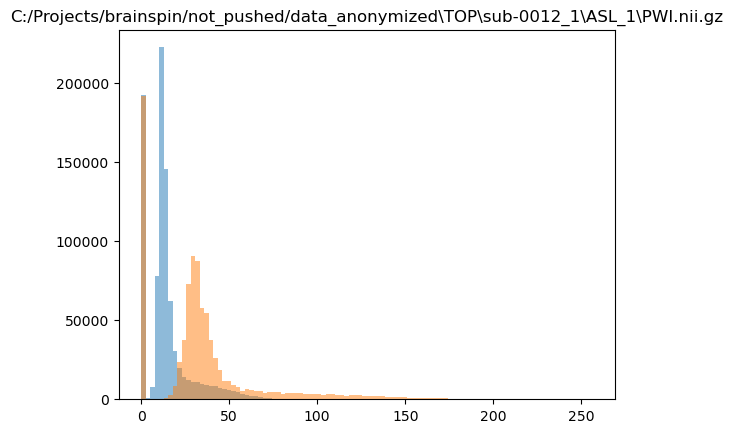

In [13]:
darker_images = []
for name, image in together_2:
    image= skimage.exposure.rescale_intensity(image, out_range=(0, 256))
    pixvals = image
    pixvals = ((pixvals - pixvals.min()) / (pixvals.max()-pixvals.min())) * 100
    darker_images.append((name, pixvals))
    plt.hist(pixvals.ravel(),bins=100,range=[image.min(),image.max()], alpha = 0.5)
    plt.hist(image.ravel(),bins=100,range=[image.min(),image.max()], alpha = 0.5)
    plt.title(name)
    plt.show()


In [14]:
mold.SliceViewer(together_2[3][1])

interactive(children=(Dropdown(description='View:', options=('axial', 'sag', 'cor'), value='axial'), Output())…

In [15]:
mold.SliceViewer(darker_images[3][1])

interactive(children=(Dropdown(description='View:', options=('axial', 'sag', 'cor'), value='axial'), Output())…